# Application du modèle économétrique

Nous allons appliquer notre modèle translog aux différentes variables construites précédemment. 


In [2]:
import os 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import statsmodels.api as sm

## 1. Construction de la base nécessaire à l'application du modèle

On crée une base contenant la variable d'intérêt Y (les points ISA), les variables explicatives et les variables de contrôle.

In [3]:
VAR_CTRL = pd.read_csv('https://raw.githubusercontent.com/VincianeDesbois/Hopitaux_Production/main/Variables_controle.csv',  sep = ',')
VAR_EXPL = pd.read_csv('https://raw.githubusercontent.com/VincianeDesbois/Hopitaux_Production/main/VAR_EXPL_CAT.csv',  sep = ',')
VAR_EXPL_SPL = pd.read_csv('https://raw.githubusercontent.com/VincianeDesbois/Hopitaux_Production/main/VAR_EXPL_SPL.csv',  sep = ',')

In [4]:
del VAR_EXPL['Unnamed: 0']
del VAR_EXPL_SPL['Unnamed: 0']

In [5]:
VAR_EXPL.columns

Index(['Numero_finess', 'Médecins libéraux',
       'Autres personnels médicaux libéraux', 'Médecins salariés',
       'Autres personnels médicaux salariés',
       'Personnels de direction et administratifs',
       'Personnels des services de soins', 'Personnels éducatifs et sociaux',
       'Personnels médico-techniques', 'Personnels techniques et ouvriers',
       'Points_ISA', 'stjr', 'Internes', 'Personnel médical',
       'Personnel médical si LIB=0.1', 'Personnel médical si LIB=0.9',
       'STJR_1', 'STJR_2', 'STJR_3'],
      dtype='object')

In [6]:
df = pd.merge(VAR_EXPL, VAR_CTRL, on=['Numero_finess'])
df.rename(columns = {'Points_ISA_x': 'Points_ISA', 'stjr_x': 'stjr'}, inplace=True)
df.drop(['Points_ISA_y','stjr_y'], axis=1, inplace=True)


In [7]:
df = pd.merge(df, VAR_EXPL_SPL)
df

,Numero_finess,Médecins libéraux,Autres personnels médicaux libéraux,Médecins salariés,Autres personnels médicaux salariés,Personnels de direction et administratifs,Personnels des services de soins,Personnels éducatifs et sociaux,Personnels médico-techniques,Personnels techniques et ouvriers,...,Population,Dep Moyenne Salaires Horaires,Dep Moyenne Salaires Cadre Horaires,Dep Moyenne Salaires Prof Intermédiaire Horaires,Dep Moyenne Salaires Employé Horaires,Moyenne Revenus Fiscaux Départementaux,Bloc_politique,Autre sans internes,Autre sans direction et administratif,Autre sans techniques et ouvriers
0,010008407,0.0,0.0,18.490,14.330,21.196667,97.323333,0.846667,9.206667,26.440,...,24188.0,11.410345,21.963793,12.558621,8.743103,12509.0,Droite à extrême droite,57.690,36.493333,31.250
1,010009132,0.0,0.0,1.795,0.070,4.175000,46.700000,1.065000,1.130000,13.465,...,1485.0,11.410345,21.963793,12.558621,8.743103,12509.0,Droite à extrême droite,19.835,15.660000,6.370
2,010780054,4.5,1.0,102.600,44.530,118.605000,388.590000,4.930000,107.660000,112.630,...,5287.0,11.410345,21.963793,12.558621,8.743103,12509.0,Centre droit à droite,343.825,420.310000,426.285
3,010780062,0.0,0.0,19.450,10.100,58.450000,336.540000,5.450000,29.320000,57.570,...,8002.0,11.410345,21.963793,12.558621,8.743103,12509.0,Centre gauche à centre droit,150.790,98.790000,99.670
4,010780096,0.0,0.0,10.260,1.885,9.685000,88.475000,2.555000,2.570000,5.960,...,6392.0,11.410345,21.963793,12.558621,8.743103,12509.0,Centre gauche à centre droit,20.770,14.565000,18.290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,940000649,0.0,0.0,97.680,28.690,132.300000,468.280000,4.830000,58.750000,25.760,...,15021.0,14.178723,23.197872,13.553191,9.600000,11793.0,Centre gauche à centre droit,221.640,221.340000,327.880
1148,940000656,0.0,0.0,9.460,1.000,39.470000,93.680000,2.520000,1.060000,51.490,...,18149.0,14.178723,23.197872,13.553191,9.600000,11793.0,Extrême gauche à gauche,94.540,56.540000,44.520
1149,940000664,0.0,0.0,202.110,79.550,459.580000,904.180000,9.700000,404.530000,126.770,...,47414.0,14.178723,23.197872,13.553191,9.600000,11793.0,Extrême gauche à gauche,1000.580,943.000000,1275.810
1150,950000406,0.0,0.0,3.510,1.260,13.950000,78.740000,1.980000,5.580000,2.360,...,11160.0,13.710526,22.919737,13.531579,9.663158,8826.0,Centre droit à droite,23.870,9.920000,21.510


On obtient bien 1152 établissements (inchallah), le nombre d'établissements qui avaient des données dans les bases du personnel. On n'a donc pas pris en compte les établissements présents dans la base des variables explicatives mais dont on ne pouvait rien dire, faute de données sur leur personnel.  

On construit des variables plus générales pour nos premières analyses : on regroupe les différentes mesures des ressources techniques des hôpitaux dans la variable Capital_Tech et les différents types de personnels libéraux et salariés dans les mêmes catégorie.

In [8]:
df = df.assign(Capital_tech = df['Capital_Bloc'] + df['Capital_imagerie'] + df['Capital_Examens_biologiques'] 
               + df['Capital_telemed'], 
              Médecins = df['Médecins libéraux'] + df['Médecins salariés'],
              Autres_personnels_médicaux = df['Autres personnels médicaux libéraux'] +df['Autres personnels médicaux salariés'])
df

,Numero_finess,Médecins libéraux,Autres personnels médicaux libéraux,Médecins salariés,Autres personnels médicaux salariés,Personnels de direction et administratifs,Personnels des services de soins,Personnels éducatifs et sociaux,Personnels médico-techniques,Personnels techniques et ouvriers,...,Dep Moyenne Salaires Prof Intermédiaire Horaires,Dep Moyenne Salaires Employé Horaires,Moyenne Revenus Fiscaux Départementaux,Bloc_politique,Autre sans internes,Autre sans direction et administratif,Autre sans techniques et ouvriers,Capital_tech,Médecins,Autres_personnels_médicaux
0,010008407,0.0,0.0,18.490,14.330,21.196667,97.323333,0.846667,9.206667,26.440,...,12.558621,8.743103,12509.0,Droite à extrême droite,57.690,36.493333,31.250,265754.0,18.490,14.330
1,010009132,0.0,0.0,1.795,0.070,4.175000,46.700000,1.065000,1.130000,13.465,...,12.558621,8.743103,12509.0,Droite à extrême droite,19.835,15.660000,6.370,0.0,1.795,0.070
2,010780054,4.5,1.0,102.600,44.530,118.605000,388.590000,4.930000,107.660000,112.630,...,12.558621,8.743103,12509.0,Centre droit à droite,343.825,420.310000,426.285,954720.0,107.100,45.530
3,010780062,0.0,0.0,19.450,10.100,58.450000,336.540000,5.450000,29.320000,57.570,...,12.558621,8.743103,12509.0,Centre gauche à centre droit,150.790,98.790000,99.670,8.0,19.450,10.100
4,010780096,0.0,0.0,10.260,1.885,9.685000,88.475000,2.555000,2.570000,5.960,...,12.558621,8.743103,12509.0,Centre gauche à centre droit,20.770,14.565000,18.290,1.0,10.260,1.885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,940000649,0.0,0.0,97.680,28.690,132.300000,468.280000,4.830000,58.750000,25.760,...,13.553191,9.600000,11793.0,Centre gauche à centre droit,221.640,221.340000,327.880,1127862.0,97.680,28.690
1148,940000656,0.0,0.0,9.460,1.000,39.470000,93.680000,2.520000,1.060000,51.490,...,13.553191,9.600000,11793.0,Extrême gauche à gauche,94.540,56.540000,44.520,0.0,9.460,1.000
1149,940000664,0.0,0.0,202.110,79.550,459.580000,904.180000,9.700000,404.530000,126.770,...,13.553191,9.600000,11793.0,Extrême gauche à gauche,1000.580,943.000000,1275.810,1872284.0,202.110,79.550
1150,950000406,0.0,0.0,3.510,1.260,13.950000,78.740000,1.980000,5.580000,2.360,...,13.531579,9.663158,8826.0,Centre droit à droite,23.870,9.920000,21.510,1.0,3.510,1.260


Nous décidons de traiter les valeurs manquantes en les remplaçant par des valeurs nulles. Nous montrerons plus tard que cela n'affecte pas nos résultats.

In [9]:
df_nanull = df.fillna(0)

In [10]:
df.columns

Index(['Numero_finess', 'Médecins libéraux',
       'Autres personnels médicaux libéraux', 'Médecins salariés',
       'Autres personnels médicaux salariés',
       'Personnels de direction et administratifs',
       'Personnels des services de soins', 'Personnels éducatifs et sociaux',
       'Personnels médico-techniques', 'Personnels techniques et ouvriers',
       'Points_ISA', 'stjr', 'Internes', 'Personnel médical',
       'Personnel médical si LIB=0.1', 'Personnel médical si LIB=0.9',
       'STJR_1', 'STJR_2', 'STJR_3', 'dep', 'Departement', 'COMINSEE',
       'Capital_Lit_MCO', 'Capital_Bloc', 'Capital_imagerie',
       'Capital_Examens_biologiques', 'Capital_telemed', 'SEJHC_MED',
       'SEJHC_CHI', 'SEJHC_OBS', 'SEJHC_MCO', 'Taux_chomage_par_dep',
       'Population', 'Dep Moyenne Salaires Horaires',
       'Dep Moyenne Salaires Cadre Horaires',
       'Dep Moyenne Salaires Prof Intermédiaire Horaires',
       'Dep Moyenne Salaires Employé Horaires',
       'Moyenne Revenus

In [54]:
#Nous passons en log tous les variables que l'on va utiliser comme facteur de production dans notre fonction translog

df1 = df_nanull.apply(lambda x: x+1 if x.name in ['Personnels de direction et administratifs',
                                                    'Personnels des services de soins', 'Personnels éducatifs et sociaux',
                                                    'Personnels médico-techniques', 'Personnels techniques et ouvriers',
                                                    'Personnel médical', 'Autre sans internes',
                                                    'Autre sans direction et administratif',
                                                    'Autre sans techniques et ouvriers',
                                                    'Personnel médical si LIB=0.1', 'Personnel médical si LIB=0.9',
                                                    'Points_ISA', 'Internes', 'Capital_Lit_MCO',
                                                    'Capital_Bloc', 'Capital_imagerie', 'Capital_Examens_biologiques',
                                                    'Capital_telemed', 'Capital_tech', 'Population', 'SEJHC_MCO'] else x)


df_log = df1.apply(lambda x: np.log(x) if x.name in ['Personnels de direction et administratifs',
                                                    'Personnels des services de soins', 'Personnels éducatifs et sociaux',
                                                    'Personnels médico-techniques', 'Personnels techniques et ouvriers',
                                                    'Personnel médical', 'Autre sans internes',
                                                    'Autre sans direction et administratif',
                                                    'Autre sans techniques et ouvriers',
                                                    'Personnel médical si LIB=0.1', 'Personnel médical si LIB=0.9',
                                                    'Points_ISA', 'Internes', 'Capital_Lit_MCO',
                                                    'Capital_Bloc', 'Capital_imagerie', 'Capital_Examens_biologiques',
                                                    'Capital_telemed', 'Capital_tech', 'Population', 'SEJHC_MCO'] else x)




df_log['Personnel médical'].min()


0.0

In [53]:
print(df1['Personnel médical'].mean())
df_nanull['Personnel médical'].mean()

60.37442916549427


59.37442916549425

In [55]:
dfm = df_log.copy()
for i in ['Personnel médical', 'Autre sans internes',
            'Autre sans direction et administratif',
            'Autre sans techniques et ouvriers',
            'Personnels de direction et administratifs',
            'Personnels des services de soins',
            'Personnels techniques et ouvriers',
            'Internes', 'Capital_Lit_MCO','Capital_tech',
             'Capital_Bloc', 'Capital_imagerie', 'Capital_Examens_biologiques',
         'Personnel médical si LIB=0.1', 'Personnel médical si LIB=0.9']:
    for j in ['Personnel médical', 'Autre sans internes',
            'Autre sans direction et administratif',
            'Autre sans techniques et ouvriers',
            'Personnels de direction et administratifs',
            'Personnels des services de soins',
            'Personnels techniques et ouvriers',
            'Internes', 'Capital_Lit_MCO','Capital_tech',
            'Capital_Bloc', 'Capital_imagerie', 'Capital_Examens_biologiques',
             'Personnel médical si LIB=0.1', 'Personnel médical si LIB=0.9']:
        if i >= j :
            dfm.insert(0, i + ' x ' + j, df_log[i]*df_log[j])
    
dfm

,Personnel médical si LIB=0.9 x Personnel médical si LIB=0.9,Personnel médical si LIB=0.9 x Personnel médical si LIB=0.1,Personnel médical si LIB=0.9 x Capital_Examens_biologiques,Personnel médical si LIB=0.9 x Capital_imagerie,Personnel médical si LIB=0.9 x Capital_Bloc,Personnel médical si LIB=0.9 x Capital_tech,Personnel médical si LIB=0.9 x Capital_Lit_MCO,Personnel médical si LIB=0.9 x Internes,Personnel médical si LIB=0.9 x Autre sans techniques et ouvriers,Personnel médical si LIB=0.9 x Autre sans direction et administratif,...,Dep Moyenne Salaires Prof Intermédiaire Horaires,Dep Moyenne Salaires Employé Horaires,Moyenne Revenus Fiscaux Départementaux,Bloc_politique,Autre sans internes,Autre sans direction et administratif,Autre sans techniques et ouvriers,Capital_tech,Médecins,Autres_personnels_médicaux
0,12.397810,12.397810,43.978947,6.308879,7.321823,43.979106,16.319123,0.000000,12.230439,12.760868,...,12.558621,8.743103,12509.0,Droite à extrême droite,4.072269,3.624163,3.473518,12.490330,18.490,14.330
1,1.107900,1.107900,0.000000,0.000000,0.000000,0.000000,2.523949,0.000000,2.102419,2.960886,...,12.558621,8.743103,12509.0,Droite à extrême droite,3.036634,2.813011,1.997418,0.000000,1.795,0.070
2,25.631791,25.341713,69.710241,12.140028,12.985787,69.710368,29.938794,26.724283,30.667573,30.596277,...,12.558621,8.743103,12509.0,Centre droit à droite,5.843037,6.043369,6.057451,13.769174,107.100,45.530
3,11.692055,11.692055,0.000000,5.503255,5.503255,7.513112,15.535182,6.866816,15.769590,15.739568,...,12.558621,8.743103,12509.0,Centre gauche à centre droit,5.022498,4.603068,4.611848,2.197225,19.450,10.100
4,6.635990,6.635990,0.000000,1.785576,0.000000,1.785576,10.547201,3.863091,7.624018,7.071298,...,12.558621,8.743103,12509.0,Centre gauche à centre droit,3.080533,2.745025,2.959587,0.693147,10.260,1.885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,23.494342,23.494342,67.548279,10.650159,8.684831,67.548335,27.100052,23.703993,28.092281,26.194715,...,13.553191,9.600000,11793.0,Centre gauche à centre droit,5.405556,5.404208,5.795693,13.935835,97.680,28.690
1148,5.948051,5.948051,0.000000,0.000000,0.000000,0.000000,9.860447,2.205264,9.311948,9.883443,...,13.553191,9.600000,11793.0,Extrême gauche à gauche,4.559545,4.052480,3.818152,0.000000,9.460,1.000
1149,31.857499,31.857499,81.517857,16.619134,16.619134,81.517965,33.674392,33.859466,40.368316,38.663789,...,13.553191,9.600000,11793.0,Extrême gauche à gauche,6.909334,6.850126,7.152120,14.442670,202.110,79.550
1150,3.071859,3.071859,0.000000,1.214860,0.000000,1.214860,5.336049,0.000000,5.457750,4.189931,...,13.531579,9.663158,8826.0,Centre droit à droite,3.213662,2.390596,3.113960,0.693147,3.510,1.260


In [56]:
dfm.columns[:30]

Index(['Personnel médical si LIB=0.9 x Personnel médical si LIB=0.9',
       'Personnel médical si LIB=0.9 x Personnel médical si LIB=0.1',
       'Personnel médical si LIB=0.9 x Capital_Examens_biologiques',
       'Personnel médical si LIB=0.9 x Capital_imagerie',
       'Personnel médical si LIB=0.9 x Capital_Bloc',
       'Personnel médical si LIB=0.9 x Capital_tech',
       'Personnel médical si LIB=0.9 x Capital_Lit_MCO',
       'Personnel médical si LIB=0.9 x Internes',
       'Personnel médical si LIB=0.9 x Autre sans techniques et ouvriers',
       'Personnel médical si LIB=0.9 x Autre sans direction et administratif',
       'Personnel médical si LIB=0.9 x Autre sans internes',
       'Personnel médical si LIB=0.9 x Personnel médical',
       'Personnel médical si LIB=0.1 x Personnel médical si LIB=0.1',
       'Personnel médical si LIB=0.1 x Capital_Examens_biologiques',
       'Personnel médical si LIB=0.1 x Capital_imagerie',
       'Personnel médical si LIB=0.1 x Capital_

## 2. Justification du modèle choisi

### 2.1 Le passage au log

On commence par vérifier que nos variables principales sont corrélées avec Y (la production en points ISA) log-linéairement plutôt que linéairement. On prend pour exemples trois facteurs de production essentielles : les médecins, le personnel de service de soins (notamment infirmier.ère.s) et le nombre de lits en MCO. 

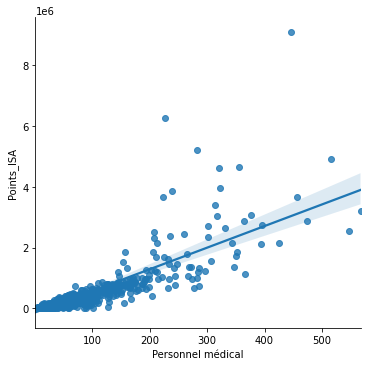

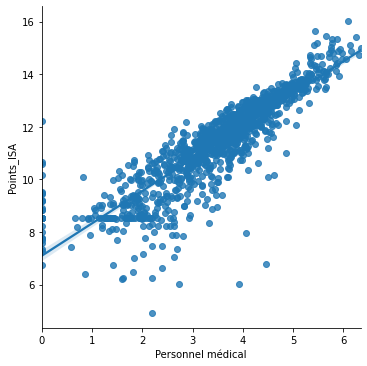

In [57]:

#Pour les médecins salariés, on enlève les valeurs nulles (transformé en log, ce sont les -infini que l'on a recodé en -3) 
# sinon elles baissent artificiellement la droite de régression et rend les graphes moins lisibles

#index_null = df[ df['Personnel Médical'] == 0 ].index
#index_null_log = df_log[ df_log['Personnel Médical'] == -3 ].index

#df_nnull = df.drop(index_null)
#df_log_nnull = df_log.drop(index_null_log)

sns.lmplot(x = 'Personnel médical', y = 'Points_ISA', data = df)
plt.savefig("C:/Users/mille/OneDrive/Documents/ENSAE/2ème année/Stat App/Graphes/reg med.pdf", bbox_inches='tight')
sns.lmplot(x = 'Personnel médical', y = 'Points_ISA', data = df_log)
plt.savefig("C:/Users/mille/OneDrive/Documents/ENSAE/2ème année/Stat App/Graphes/reg med log.pdf", bbox_inches='tight')



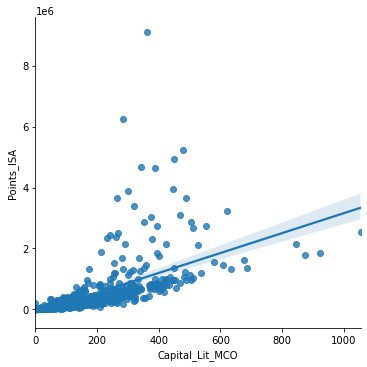

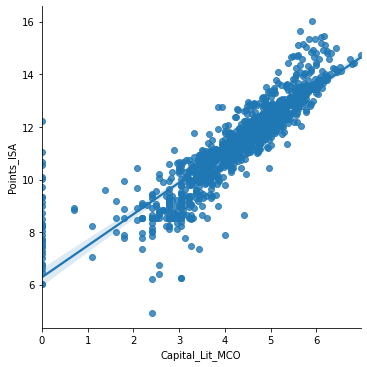

In [58]:
sns.lmplot(x = 'Capital_Lit_MCO', y = 'Points_ISA', data = df)
plt.savefig("C:/Users/mille/OneDrive/Documents/ENSAE/2ème année/Stat App/Graphes/reg lits.pdf", bbox_inches='tight')
sns.lmplot(x = 'Capital_Lit_MCO', y = 'Points_ISA', data = df_log)
plt.savefig("C:/Users/mille/OneDrive/Documents/ENSAE/2ème année/Stat App/Graphes/reg lits log.pdf", bbox_inches='tight')

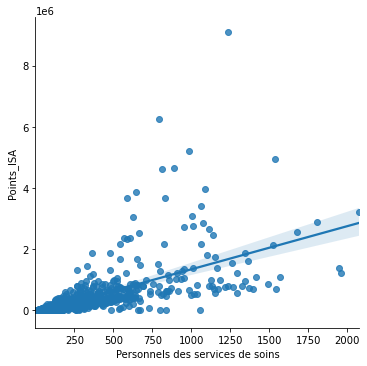

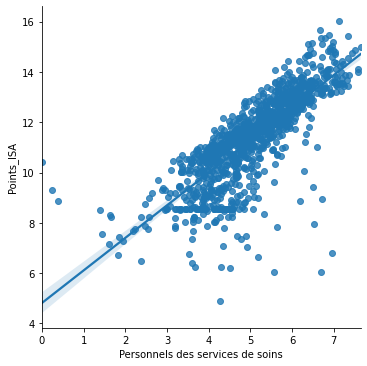

In [59]:
sns.lmplot(x = 'Personnels des services de soins', y = 'Points_ISA', data = df)
sns.lmplot(x = 'Personnels des services de soins', y = 'Points_ISA', data = df_log)

Ces représentations graphiques et régressions montrent bien la pertinence du modèle translog puisque nos variables sont bien plus corrélées log-linéairement que linéairement (avec des coefficients positifs). Cela montre bien que la productivité marginale de chaque facteur de production est positive et décroissante et que les fonctions de production de type Cobb-Douglass et Translog sont adaptés à notre analyse. 

### 2.2 Comparaison entre un modèle de type Cobb-Douglas et un modèle translog

#### Premiers résultats généraux : 

In [60]:
X = dfm[['Personnel médical', 
        'Personnels de direction et administratifs',
       'Personnels des services de soins', 'Personnels éducatifs et sociaux',
       'Personnels médico-techniques', 
        'Personnels techniques et ouvriers',
        'Internes',  
        'Capital_Lit_MCO', 'Capital_imagerie', 'Capital_Bloc', 'Capital_Examens_biologiques', 
         'STJR_1', 'STJR_2', 'STJR_3', 'Population']]
X = sm.add_constant(X) # on ajoute une constante, sinon la régression se fait sans, par défaut
y = dfm['Points_ISA']

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

import matplotlib.pyplot as plt
#plt.rc('figure', figsize=(12, 7))
#plt.text(0.01, 0.05, str(results.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
#plt.axis('off')
#plt.tight_layout()
#plt.savefig('C:/Users/mille/OneDrive/Documents/ENSAE/2ème année/Stat App/output.png')

                            OLS Regression Results                            
Dep. Variable:             Points_ISA   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     682.6
Date:                Wed, 19 May 2021   Prob (F-statistic):               0.00
Time:                        14:43:14   Log-Likelihood:                -989.18
No. Observations:                1152   AIC:                             2008.
Df Residuals:                    1137   BIC:                             2084.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

On obtient des coefficients en grande majorité significatifs à 5%, on peut donc les interpréter. 

ATTENTION c'est une régression log-log donc les coefficients s'interprètent comme des % : 1% de Xi en plus augmente de beta(Xi)% la production.

#### Vérification que l'hypothèse faite sur les ETP des libéraux n'affecte pas nos résultats
Pour vérifier que notre hypothèse d'estimer les ETP des personnels libéraux en multipliant leurs effectifs par 0.5 n'affecte pas nos résultats, nous effectuons la même régression en remplaçant cette hypothèse par 0.1 puis par 0.9. 
Cette régression sera témoin pour toutes les autres Cobb-Douglass de l'absence d'effet de cette hypothèse sur les résultats.

In [61]:
X = dfm[['Personnel médical si LIB=0.1', 'Personnels de direction et administratifs',
       'Personnels des services de soins', 'Personnels éducatifs et sociaux',
       'Personnels médico-techniques', 'Personnels techniques et ouvriers', 'Internes',  
        'Capital_Lit_MCO', 'Capital_imagerie', 'Capital_Bloc', 'Capital_Examens_biologiques', 
         'STJR_1', 'STJR_2', 'STJR_3','Population']]
X = sm.add_constant(X) # on ajoute une constante, sinon la régression se fait sans, par défaut
y = dfm['Points_ISA']

model_bis = sm.OLS(y, X)
results_bis = model_bis.fit()
#print(results_bis.summary())

In [62]:
X = dfm[['Personnel médical si LIB=0.9', 'Personnels de direction et administratifs',
       'Personnels des services de soins', 'Personnels éducatifs et sociaux',
       'Personnels médico-techniques', 'Personnels techniques et ouvriers', 'Internes',  
        'Capital_Lit_MCO', 'Capital_imagerie', 'Capital_Bloc', 'Capital_Examens_biologiques', 
        'STJR_1', 'STJR_2', 'STJR_3', 'Population']]
X = sm.add_constant(X) # on ajoute une constante, sinon la régression se fait sans, par défaut
y = dfm['Points_ISA']

model_ter = sm.OLS(y, X)
results_ter = model_ter.fit()
#print(results_ter.summary())

In [63]:
comp_lib = pd.DataFrame(index = [results_bis.params, results.params, results_ter.params])
comp_lib.to_excel("C:/Users/mille/OneDrive/Documents/ENSAE/2ème année/Stat App/table etp_lib.xlsx")


In [64]:
etp_lib = pd.read_excel("C:/Users/mille/OneDrive/Documents/ENSAE/2ème année/Stat App/table etp_lib.xlsx")
etp_lib

,Unnamed: 0,Unnamed: 1,Unnamed: 2
0,5.700384,5.656857,5.628976
1,0.287144,0.249147,0.197224
2,0.029347,0.026041,0.038067
3,0.041605,0.049174,0.055724
4,-0.109261,-0.079750,-0.067191
5,0.111617,0.126516,0.134219
6,-0.113207,-0.109000,-0.109581
7,0.095283,0.123331,0.135122
8,0.511853,0.502678,0.505469
9,0.057324,0.067581,0.073872


Tous les coefficients sont très proches (le seul qui diffère un peu mais parce très petit concerne les personnels éducatifs et sociaux dont le coefficient n'est de toute façon pas significatif)

#### On retient le modèle Cobb-Douglass pour le moment et on passe à la comparaison selon le statut juridique
On constate qu'avec autant de variables, le modèle translog n'est pas pertinent, les p-values élevées montrent que beaucoup de coefficients ne sont pas significatifs. On garde donc pour le moment le modèle simple.
On souhaite à présent comparer ces variables entre les hôpitaux privés, publics et privés à but non lucratif. 

In [65]:
# 1 public 2 privé lucratif 3 privé non lucratif

index_non_public = dfm[ dfm['stjr'] != 1].index
index_non_privé = dfm[ dfm['stjr'] != 2].index
index_non_pnl = dfm[ dfm['stjr'] != 3].index
index_privé = dfm[ dfm['stjr'] == 2].index
index_public = dfm[ dfm['stjr'] == 1].index

dfm_public = dfm.drop(index_non_public)
dfm_privé = dfm.drop(index_non_privé)
dfm_pnl = dfm.drop(index_non_pnl)
dfm_public_pnl = dfm.drop(index_privé)
dfm_privé_pnl = dfm.drop(index_public)

In [66]:
print("Nombre d'hôpitaux publics : ", dfm_public['stjr'].count())
print("Nombre d'hôpitaux privés : ", dfm_privé['stjr'].count())
print("Nombre d'hôpitaux privés à but non lucratif : ", dfm_pnl['stjr'].count())

Nombre d'hôpitaux publics :  518
Nombre d'hôpitaux privés :  461
Nombre d'hôpitaux privés à but non lucratif :  173


In [67]:
# Régression sur les hôpitaux publics : 

X = dfm_public[['Personnel médical', 'Personnels de direction et administratifs',
       'Personnels des services de soins', 
                #'Personnels éducatifs et sociaux',
       'Personnels médico-techniques', 
                #'Personnels techniques et ouvriers', 
                'Internes', 
        'Capital_Lit_MCO', 'Capital_imagerie', 'Capital_Bloc', 
                'Capital_Examens_biologiques', 
                'Population']]
X = sm.add_constant(X) # on ajoute une constante, sinon la régression se fait sans, par défaut
y = dfm_public['Points_ISA']

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             Points_ISA   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     663.1
Date:                Wed, 19 May 2021   Prob (F-statistic):          9.30e-284
Time:                        14:43:41   Log-Likelihood:                -418.03
No. Observations:                 518   AIC:                             858.1
Df Residuals:                     507   BIC:                             904.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

In [68]:
# Régression sur les hôpitaux privés en enlevant le personnel médical

X = dfm_privé[['Personnels de direction et administratifs',
       'Personnels des services de soins', 
               #'Personnels éducatifs et sociaux',
       'Personnels médico-techniques', 
       'Personnels techniques et ouvriers', 
               'Internes', 
        'Capital_Lit_MCO', 'Capital_imagerie', 'Capital_Bloc', 'Capital_Examens_biologiques','Population']]
X = sm.add_constant(X) # on ajoute une constante, sinon la régression se fait sans, par défaut
y = dfm_privé['Points_ISA']

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             Points_ISA   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     240.4
Date:                Wed, 19 May 2021   Prob (F-statistic):          1.73e-173
Time:                        14:44:00   Log-Likelihood:                -329.28
No. Observations:                 461   AIC:                             680.6
Df Residuals:                     450   BIC:                             726.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

In [69]:
# Régression sur les hôpitaux privés à but non lucratif

X = dfm_pnl[['Personnel médical', 'Personnels de direction et administratifs',
       'Personnels des services de soins', 
             #'Personnels éducatifs et sociaux',
       'Personnels médico-techniques', 'Personnels techniques et ouvriers', 'Internes',
        'Capital_Lit_MCO', 'Capital_imagerie', 'Capital_Bloc', 'Capital_Examens_biologiques', 'Population']]
X = sm.add_constant(X) # on ajoute une constante, sinon la régression se fait sans, par défaut
y = dfm_pnl['Points_ISA']

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             Points_ISA   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     147.2
Date:                Wed, 19 May 2021   Prob (F-statistic):           5.24e-78
Time:                        14:44:17   Log-Likelihood:                -139.33
No. Observations:                 173   AIC:                             302.7
Df Residuals:                     161   BIC:                             340.5
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

On voit que cette dernière régression donne des coefficients particulièrement peu significatifs, donc on essaie de regrouper les hôpitaux pnl avec les publics.

In [70]:
X = dfm_public_pnl[['Personnel médical', 'Personnels de direction et administratifs',
       'Personnels des services de soins', 
             #'Personnels éducatifs et sociaux',
       'Personnels médico-techniques', 'Personnels techniques et ouvriers', 'Internes',
        'Capital_Lit_MCO', 'Capital_imagerie', 'Capital_Bloc', 'Capital_Examens_biologiques', 'Population']]
X = sm.add_constant(X) # on ajoute une constante, sinon la régression se fait sans, par défaut
y = dfm_public_pnl['Points_ISA']

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             Points_ISA   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     719.2
Date:                Wed, 19 May 2021   Prob (F-statistic):               0.00
Time:                        14:44:18   Log-Likelihood:                -582.41
No. Observations:                 691   AIC:                             1189.
Df Residuals:                     679   BIC:                             1243.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

Cela modifie un peu les coefficients par rapport à la régression sur les hôpitaux publics, mais on a plus de significativité. 
Bien que la gestion du facteur travail en pnl soit la même qu'en hôpitaux privé, on voit directement qu'ils sont beaucoup plus proches en terme de productivité des différents types de personnels des hôpitaux publics avec qui ils partagent le régime de budget/coûts. 

ATTENTION ces régressions ne sont pas très significatives, voir si on peut arranger avec d'autres variables ! 

### Régression translog

Pour aller plus loin dans l'analyse, on utilise le modèle translog comme fonction de production, ce qui nous permet de calculer des élasticités de substitution notamment. Ce modèle est plutôt plus réaliste que la Cobb-Douglas qui suppose des élasticités de substitution unitaires entre les facteurs (plus rigide). 

In [71]:
df.columns

Index(['Numero_finess', 'Médecins libéraux',
       'Autres personnels médicaux libéraux', 'Médecins salariés',
       'Autres personnels médicaux salariés',
       'Personnels de direction et administratifs',
       'Personnels des services de soins', 'Personnels éducatifs et sociaux',
       'Personnels médico-techniques', 'Personnels techniques et ouvriers',
       'Points_ISA', 'stjr', 'Internes', 'Personnel médical',
       'Personnel médical si LIB=0.1', 'Personnel médical si LIB=0.9',
       'STJR_1', 'STJR_2', 'STJR_3', 'dep', 'Departement', 'COMINSEE',
       'Capital_Lit_MCO', 'Capital_Bloc', 'Capital_imagerie',
       'Capital_Examens_biologiques', 'Capital_telemed', 'SEJHC_MED',
       'SEJHC_CHI', 'SEJHC_OBS', 'SEJHC_MCO', 'Taux_chomage_par_dep',
       'Population', 'Dep Moyenne Salaires Horaires',
       'Dep Moyenne Salaires Cadre Horaires',
       'Dep Moyenne Salaires Prof Intermédiaire Horaires',
       'Dep Moyenne Salaires Employé Horaires',
       'Moyenne Revenus

In [72]:
X = dfm[['Personnel médical', 'Personnels de direction et administratifs',
       'Personnels des services de soins', 'Autre sans direction et administratif',
        'Capital_Lit_MCO', 'Capital_tech',
        'Capital_tech x Capital_Lit_MCO',
       'Personnels des services de soins x Capital_tech',
       'Personnels des services de soins x Capital_Lit_MCO',
       'Personnels des services de soins x Personnels de direction et administratifs',
       'Personnels des services de soins x Personnel médical',
       'Personnels de direction et administratifs x Capital_tech',
       'Personnels de direction et administratifs x Capital_Lit_MCO',
       'Personnels de direction et administratifs x Personnel médical',
       'Personnel médical x Capital_tech', 'Personnel médical x Capital_Lit_MCO',
        'Capital_tech x Capital_tech', 'Capital_Lit_MCO x Capital_Lit_MCO',
        'Personnel médical x Personnel médical', 
        'Personnels de direction et administratifs x Personnels de direction et administratifs',
        'Personnels des services de soins x Personnels des services de soins',
        'Autre sans direction et administratif x Autre sans direction et administratif',
        'Personnels des services de soins x Autre sans direction et administratif',
        'Capital_tech x Autre sans direction et administratif',
        'Personnels de direction et administratifs x Autre sans direction et administratif',
        'Personnel médical x Autre sans direction et administratif',
        'Capital_Lit_MCO x Autre sans direction et administratif','STJR_1', 'STJR_2', 'STJR_3']]

X = sm.add_constant(X) # on ajoute une constante, sinon la régression se fait sans, par défaut
y = dfm['Points_ISA']

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:             Points_ISA   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     364.9
Date:                Wed, 19 May 2021   Prob (F-statistic):               0.00
Time:                        14:44:20   Log-Likelihood:                -929.47
No. Observations:                1152   AIC:                             1919.
Df Residuals:                    1122   BIC:                             2070.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                                                                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

In [73]:
results.params.shape

(31,)

#### Vérification que l'hypothèse sur les ETP des libéraux n'affecte pas nos résultats
Avant d'aller plus loin dans notre analyse, nous procèdons exactement comme précédemment pour vérifier que cette hypothèse n'entravera pas nos estimations. 

In [74]:
X = dfm[['Personnel médical si LIB=0.1', 'Personnels de direction et administratifs',
       'Personnels des services de soins', 'Autre sans direction et administratif',
        'Capital_Lit_MCO', 'Capital_tech',
        'Capital_tech x Capital_Lit_MCO',
       'Personnels des services de soins x Capital_tech',
       'Personnels des services de soins x Capital_Lit_MCO',
       'Personnels des services de soins x Personnels de direction et administratifs',
       'Personnels des services de soins x Personnel médical si LIB=0.1',
       'Personnels de direction et administratifs x Capital_tech',
       'Personnels de direction et administratifs x Capital_Lit_MCO',
       'Personnels de direction et administratifs x Personnel médical si LIB=0.1',
       'Personnel médical si LIB=0.1 x Capital_tech', 'Personnel médical si LIB=0.1 x Capital_Lit_MCO',
        'Capital_tech x Capital_tech', 'Capital_Lit_MCO x Capital_Lit_MCO',
        'Personnel médical si LIB=0.1 x Personnel médical si LIB=0.1', 
        'Personnels de direction et administratifs x Personnels de direction et administratifs',
        'Personnels des services de soins x Personnels des services de soins',
        'Autre sans direction et administratif x Autre sans direction et administratif',
        'Personnels des services de soins x Autre sans direction et administratif',
        'Capital_tech x Autre sans direction et administratif',
        'Personnels de direction et administratifs x Autre sans direction et administratif',
        'Personnel médical si LIB=0.1 x Autre sans direction et administratif',
        'Capital_Lit_MCO x Autre sans direction et administratif', 'STJR_1', 'STJR_2', 'STJR_3']]

X = sm.add_constant(X) # on ajoute une constante, sinon la régression se fait sans, par défaut
y = dfm['Points_ISA']

model1 = sm.OLS(y, X)
results1 = model1.fit()
#print(results1.summary())


In [75]:
X = dfm[['Personnel médical si LIB=0.9', 'Personnels de direction et administratifs',
       'Personnels des services de soins', 'Autre sans direction et administratif',
        'Capital_Lit_MCO', 'Capital_tech',
        'Capital_tech x Capital_Lit_MCO',
       'Personnels des services de soins x Capital_tech',
       'Personnels des services de soins x Capital_Lit_MCO',
       'Personnels des services de soins x Personnels de direction et administratifs',
       'Personnels des services de soins x Personnel médical si LIB=0.9',
       'Personnels de direction et administratifs x Capital_tech',
       'Personnels de direction et administratifs x Capital_Lit_MCO',
       'Personnels de direction et administratifs x Personnel médical si LIB=0.9',
       'Personnel médical si LIB=0.9 x Capital_tech', 'Personnel médical si LIB=0.9 x Capital_Lit_MCO',
        'Capital_tech x Capital_tech', 'Capital_Lit_MCO x Capital_Lit_MCO',
        'Personnel médical si LIB=0.9 x Personnel médical si LIB=0.9', 
        'Personnels de direction et administratifs x Personnels de direction et administratifs',
        'Personnels des services de soins x Personnels des services de soins',
        'Autre sans direction et administratif x Autre sans direction et administratif',
        'Personnels des services de soins x Autre sans direction et administratif',
        'Capital_tech x Autre sans direction et administratif',
        'Personnels de direction et administratifs x Autre sans direction et administratif',
        'Personnel médical si LIB=0.9 x Autre sans direction et administratif',
        'Capital_Lit_MCO x Autre sans direction et administratif', 'STJR_1', 'STJR_2', 'STJR_3']]

X = sm.add_constant(X) # on ajoute une constante, sinon la régression se fait sans, par défaut
y = dfm['Points_ISA']

model9 = sm.OLS(y, X)
results9 = model9.fit()
#print(results9.summary())

In [76]:
comp_lib = pd.DataFrame(index = [results1.params, results.params, results9.params])
comp_lib

,,
5.538273,4.927206,4.820428
1.315377,0.975719,0.705581
-0.005475,0.064545,0.213948
-0.331096,0.031329,0.021173
-0.148399,-0.106257,-0.120398
0.048814,-0.035303,0.051779
0.191597,0.220835,0.238131
-0.089608,-0.104019,-0.112313
0.084869,0.077457,0.072859
-0.013687,-0.046508,-0.101667


Ici, plus de variations que précédemment, mais notre hypothèse nous semble plus crédible que celles de 0.1 ou 0.9 et on est obligé de faire un choix. Cependant, nous retenons que cela pourrait constituer un léger biais dans les analyses qui suivent.

#### Etude de notre fonction Translog :

In [77]:
#Pour vérifier la pertinence de notre modèle translog, on effectue un F-test 
# avec comme hypothèse nulle la nullité conjointe de tous les coefficients croisés

F_test_x = np.array(([0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0, 0, 0, 0, 0, 0],
                     [0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0, 0, 0, 0, 0, 0],
                     [0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0, 0, 0, 0, 0, 0],
                     [0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0, 0, 0, 0, 0, 0],
                     [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0, 0, 0, 0, 0, 0],
                     [0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0, 0, 0, 0, 0, 0],
                     [0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0, 0, 0, 0, 0, 0],
                     [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0, 0, 0, 0, 0, 0],
                     [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0, 0, 0, 0, 0, 0],
                     [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0, 0, 0, 0, 0, 0],
                     [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0, 0, 0, 0, 0, 0],
                     [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0, 0, 0, 0, 0, 0],
                     [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0, 0, 0, 0, 0, 0],
                     [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0, 0, 0, 0, 0, 0],
                     [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0, 0, 0, 0, 0, 0],
                     [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0, 0, 0, 0, 0, 0],
                     [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0, 0, 0, 0, 0, 0],
                     [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0, 0, 0, 0, 0, 0],
                     [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1, 0, 0, 0, 0, 0],
                     [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0, 1, 0, 0, 0, 0],
                     [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0, 0, 1, 0, 0, 0],
                   ))
print(results.f_test(F_test_x))

#On a bien une p-valeur très inférieure à 0.05

<F test: F=array([[22.5794682]]), p=1.6893822031030471e-71, df_denom=1.12e+03, df_num=21>


La p-valeur est largement inférieure à 0.05 donc la prise en compte des coefficients croisés est bien justifiée. 

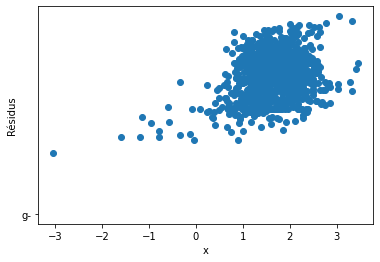

In [78]:
#On étudie les résidus (A REFAIRE)

plt.plot(dfm['Points_ISA'] - (results.params[0] + results.params[1]*dfm['Personnel médical'] + results.params[2]*dfm['Personnels de direction et administratifs'] + results.params[3]*dfm['Personnels des services de soins'] +
                                                 results.params[4]*dfm['Autre sans direction et administratif'] + results.params[5]*dfm['Capital_Lit_MCO'] + results.params[6]*dfm['Capital_tech'] + results.params[7]*dfm['Capital_tech x Capital_Lit_MCO'] +
                                                 results.params[8]*dfm['Personnels des services de soins x Capital_tech'] + results.params[9]*dfm['Personnels des services de soins x Capital_Lit_MCO'] + results.params[10]*dfm['Personnels des services de soins x Personnels de direction et administratifs'] + results.params[11]*dfm['Personnels des services de soins x Personnel médical'] +
                                                 results.params[12]*dfm['Personnels de direction et administratifs x Capital_tech'] + results.params[13]*dfm['Personnels de direction et administratifs x Capital_Lit_MCO'] + results.params[14]*dfm['Personnels de direction et administratifs x Personnel médical'] + results.params[15]*dfm['Personnel médical x Capital_tech'] +
                                                 results.params[16]*dfm['Personnel médical x Capital_Lit_MCO'] + results.params[17]*dfm['Capital_tech x Capital_tech'] + results.params[18]*dfm['Capital_Lit_MCO x Capital_Lit_MCO'] + results.params[19]*dfm['Personnel médical x Personnel médical'] +
                                                 results.params[20]*dfm['Personnels de direction et administratifs x Personnels de direction et administratifs'] + results.params[21]*dfm['Personnels des services de soins x Personnels des services de soins'] + results.params[22]*dfm['Autre sans direction et administratif x Autre sans direction et administratif'] + results.params[23]*dfm['Personnels des services de soins x Autre sans direction et administratif'] +
                                                 results.params[24]*dfm['Capital_tech x Autre sans direction et administratif'] + results.params[25]*dfm['Personnels de direction et administratifs x Autre sans direction et administratif'] + results.params[26]*dfm['Personnel médical x Autre sans direction et administratif'] + results.params[27]*dfm['Capital_Lit_MCO x Autre sans direction et administratif']),
                                                 dfm['Points_ISA'], 'o', "g-", label="residus")
plt.xlabel("x")
plt.ylabel("Résidus")
plt.show()

In [79]:
#On crée une dataframe pour calculer les élasticités de tous nos facteurs de production

df_el = pd.DataFrame()

df_el = df_el.assign(el_med = results.params[1] + results.params[11] * dfm['Personnels des services de soins']
+ results.params[14] * dfm['Personnels de direction et administratifs']
+ results.params[15] * dfm['Capital_tech']
+ results.params[16] * dfm['Capital_Lit_MCO']
+ results.params[19] * dfm['Personnel médical'] * 2
+ results.params[26] * dfm['Autre sans direction et administratif'])

df_el = df_el.assign(el_captech = results.params[6] + results.params[7] * dfm['Capital_Lit_MCO']
+ results.params[8] * dfm['Personnels des services de soins']
+ results.params[12] * dfm['Personnels de direction et administratifs']
+ results.params[15] * dfm['Personnel médical']
+ results.params[17] * dfm['Capital_tech']*2
+ results.params[24] * dfm['Autre sans direction et administratif'])

df_el = df_el.assign(el_adm = results.params[2] + results.params[10]*dfm['Personnels des services de soins'] + results.params[12]*dfm['Capital_tech']
+ results.params[13]*dfm['Capital_Lit_MCO']
+ results.params[14]*dfm['Personnel médical']
+ results.params[20]*dfm['Personnels de direction et administratifs'] *2
+ results.params[25]*dfm['Autre sans direction et administratif'])

df_el = df_el.assign(el_soins = results.params[3] + results.params[8]*dfm['Capital_tech']
+ results.params[9]*dfm['Capital_Lit_MCO']
+ results.params[10]*dfm['Personnels de direction et administratifs']
+ results.params[11]*dfm['Personnel médical']
+ results.params[21]*dfm['Personnels des services de soins']*2
+ results.params[23]*dfm['Autre sans direction et administratif'])

df_el = df_el.assign(el_lits = results.params[5] + results.params[7]*dfm['Capital_tech']
+ results.params[9]*dfm['Personnels des services de soins']
+ results.params[13]*dfm['Personnels de direction et administratifs']
+ results.params[16]*dfm['Personnel médical']
+ results.params[18]*dfm['Capital_Lit_MCO']*2
+ results.params[27]*dfm['Autre sans direction et administratif'])

df_el.mean()


el_med        0.489753
el_captech    0.071112
el_adm       -0.178654
el_soins      0.093031
el_lits       0.729967
dtype: float64

In [80]:
#Calcul des élasticités de substitution (définition de McFadden, 1963)

df_el = df_el.assign(es_med_captech = (df_el['el_med'] + df_el['el_captech']) / (df_el['el_med'] + df_el['el_captech']
                                                                        + 2*results.params[15]
                                                                        - 2*results.params[19]*df_el['el_captech']/df_el['el_med']
                                                                        - 2*results.params[17]*df_el['el_med']/df_el['el_captech']))

df_el = df_el.assign(es_med_lits = (df_el['el_med'] + df_el['el_lits']) / (df_el['el_med'] + df_el['el_lits']
                                                                        + 2*results.params[16]
                                                                        - 2*results.params[19]*df_el['el_lits']/df_el['el_med']
                                                                        - 2*results.params[18]*df_el['el_med']/df_el['el_lits']))

df_el = df_el.assign(es_med_soins = (df_el['el_med'] + df_el['el_soins']) / (df_el['el_med'] + df_el['el_soins']
                                                                        + 2*results.params[11]
                                                                        - 2*results.params[19]*df_el['el_soins']/df_el['el_med']
                                                                        - 2*results.params[21]*df_el['el_med']/df_el['el_soins']))

df_el = df_el.assign(es_med_adm = (df_el['el_med'] + df_el['el_adm']) / (df_el['el_med'] + df_el['el_adm']
                                                                        + 2*results.params[14]
                                                                        - 2*results.params[19]*df_el['el_adm']/df_el['el_med']
                                                                        - 2*results.params[20]*df_el['el_med']/df_el['el_adm']))

df_el = df_el.assign(es_adm_soins = (df_el['el_adm'] + df_el['el_soins']) / (df_el['el_soins'] + df_el['el_adm']
                                                                        + 2*results.params[10]
                                                                        - 2*results.params[20]*df_el['el_soins']/df_el['el_adm']
                                                                        - 2*results.params[21]*df_el['el_adm']/df_el['el_soins']))

df_el = df_el.assign(es_adm_captech = (df_el['el_adm'] + df_el['el_captech']) / (df_el['el_adm'] + df_el['el_captech']
                                                                        + 2*results.params[12]
                                                                        - 2*results.params[20]*df_el['el_captech']/df_el['el_adm']
                                                                        - 2*results.params[17]*df_el['el_adm']/df_el['el_captech']))

df_el = df_el.assign(es_adm_lits = (df_el['el_adm'] + df_el['el_lits']) / (df_el['el_adm'] + df_el['el_lits']
                                                                        + 2*results.params[13]
                                                                        - 2*results.params[20]*df_el['el_lits']/df_el['el_adm']
                                                                        - 2*results.params[18]*df_el['el_adm']/df_el['el_lits']))

df_el = df_el.assign(es_soins_captech = (df_el['el_soins'] + df_el['el_captech']) / (df_el['el_soins'] + df_el['el_captech']
                                                                        + 2*results.params[8]
                                                                        - 2*results.params[21]*df_el['el_captech']/df_el['el_soins']
                                                                        - 2*results.params[17]*df_el['el_soins']/df_el['el_captech']))

df_el = df_el.assign(es_soins_lits = (df_el['el_soins'] + df_el['el_lits']) / (df_el['el_soins'] + df_el['el_lits']
                                                                        + 2*results.params[9]
                                                                        - 2*results.params[21]*df_el['el_lits']/df_el['el_soins']
                                                                        - 2*results.params[18]*df_el['el_soins']/df_el['el_lits']))
df_el.mean()

el_med              0.489753
el_captech          0.071112
el_adm             -0.178654
el_soins            0.093031
el_lits             0.729967
es_med_captech      0.952065
es_med_lits        -1.002423
es_med_soins        0.533859
es_med_adm         -1.207198
es_adm_soins        1.197061
es_adm_captech      0.579743
es_adm_lits         0.156031
es_soins_captech    0.533607
es_soins_lits       1.582187
dtype: float64

Elasticité de substitution positive = substituts ; négative (surtout proche de 0) = compléments
% de changement dans le ratio d'utilisation suite à 1% de changement dans la ratio de la productivité marginale de chacun. 

In [81]:
dfm.columns

Index(['Personnel médical si LIB=0.9 x Personnel médical si LIB=0.9',
       'Personnel médical si LIB=0.9 x Personnel médical si LIB=0.1',
       'Personnel médical si LIB=0.9 x Capital_Examens_biologiques',
       'Personnel médical si LIB=0.9 x Capital_imagerie',
       'Personnel médical si LIB=0.9 x Capital_Bloc',
       'Personnel médical si LIB=0.9 x Capital_tech',
       'Personnel médical si LIB=0.9 x Capital_Lit_MCO',
       'Personnel médical si LIB=0.9 x Internes',
       'Personnel médical si LIB=0.9 x Autre sans techniques et ouvriers',
       'Personnel médical si LIB=0.9 x Autre sans direction et administratif',
       ...
       'Dep Moyenne Salaires Prof Intermédiaire Horaires',
       'Dep Moyenne Salaires Employé Horaires',
       'Moyenne Revenus Fiscaux Départementaux', 'Bloc_politique',
       'Autre sans internes', 'Autre sans direction et administratif',
       'Autre sans techniques et ouvriers', 'Capital_tech', 'Médecins',
       'Autres_personnels_médicaux']

In [82]:
X = dfm[['Personnel médical', 'Personnels techniques et ouvriers',
       'Personnels des services de soins', 'Autre sans techniques et ouvriers',
        'Capital_Lit_MCO', 'Capital_tech',
        'Capital_tech x Capital_Lit_MCO',
       'Personnels des services de soins x Capital_tech',
       'Personnels des services de soins x Capital_Lit_MCO',
       'Personnels techniques et ouvriers x Personnels des services de soins',
       'Personnels des services de soins x Personnel médical',
       'Personnels techniques et ouvriers x Capital_tech',
       'Personnels techniques et ouvriers x Capital_Lit_MCO',
       'Personnels techniques et ouvriers x Personnel médical',
       'Personnel médical x Capital_tech', 'Personnel médical x Capital_Lit_MCO',
        'Capital_tech x Capital_tech', 'Capital_Lit_MCO x Capital_Lit_MCO',
        'Personnel médical x Personnel médical', 
        'Personnels techniques et ouvriers x Personnels techniques et ouvriers',
        'Personnels des services de soins x Personnels des services de soins',
        'Autre sans techniques et ouvriers x Autre sans techniques et ouvriers',
        'Personnels des services de soins x Autre sans techniques et ouvriers',
        'Capital_tech x Autre sans techniques et ouvriers',
        'Personnels techniques et ouvriers x Autre sans techniques et ouvriers',
        'Personnel médical x Autre sans techniques et ouvriers',
        'Capital_Lit_MCO x Autre sans techniques et ouvriers','STJR_1', 'STJR_2', 'STJR_3']]

X = sm.add_constant(X) # on ajoute une constante, sinon la régression se fait sans, par défaut
y = dfm['Points_ISA']

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             Points_ISA   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     358.0
Date:                Wed, 19 May 2021   Prob (F-statistic):               0.00
Time:                        14:44:25   Log-Likelihood:                -939.51
No. Observations:                1152   AIC:                             1939.
Df Residuals:                    1122   BIC:                             2091.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                                                                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

In [83]:
#Calcul des élasticités :

df_el1 = pd.DataFrame()

df_el1 = df_el1.assign(el_med = results.params[1] + results.params[11] * dfm['Personnels des services de soins']
+ results.params[14] * dfm['Personnels techniques et ouvriers']
+ results.params[15] * dfm['Capital_tech']
+ results.params[16] * dfm['Capital_Lit_MCO']
+ results.params[19] * dfm['Personnel médical'] * 2
+ results.params[26] * dfm['Autre sans techniques et ouvriers'])

df_el1 = df_el1.assign(el_captech = results.params[6] + results.params[7] * dfm['Capital_Lit_MCO']
+ results.params[8] * dfm['Personnels des services de soins']
+ results.params[12] * dfm['Personnels techniques et ouvriers']
+ results.params[15] * dfm['Personnel médical']
+ results.params[17] * dfm['Capital_tech']*2
+ results.params[24] * dfm['Autre sans techniques et ouvriers'])

df_el1 = df_el1.assign(el_ouv = results.params[2] + results.params[10]*dfm['Personnels des services de soins'] + results.params[12]*dfm['Capital_tech']
+ results.params[13]*dfm['Capital_Lit_MCO']
+ results.params[14]*dfm['Personnel médical']
+ results.params[20]*dfm['Personnels techniques et ouvriers'] *2
+ results.params[25]*dfm['Autre sans techniques et ouvriers'])

df_el1 = df_el1.assign(el_soins = results.params[3] + results.params[8]*dfm['Capital_tech']
+ results.params[9]*dfm['Capital_Lit_MCO']
+ results.params[10]*dfm['Personnels techniques et ouvriers']
+ results.params[11]*dfm['Personnel médical']
+ results.params[21]*dfm['Personnels des services de soins']*2
+ results.params[23]*dfm['Autre sans techniques et ouvriers'])

df_el1 = df_el1.assign(el_lits = results.params[5] + results.params[7]*dfm['Capital_tech']
+ results.params[9]*dfm['Personnels des services de soins']
+ results.params[13]*dfm['Personnels techniques et ouvriers']
+ results.params[16]*dfm['Personnel médical']
+ results.params[18]*dfm['Capital_Lit_MCO']*2
+ results.params[27]*dfm['Autre sans techniques et ouvriers'])

df_el1.mean()

el_med        0.518296
el_captech    0.067063
el_ouv       -0.085786
el_soins      0.046690
el_lits       0.752803
dtype: float64

In [84]:
#Calcul des élasticités de substitution (définition de McFadden, 1963)

df_el1 = df_el1.assign(es_med_captech = (df_el1['el_med'] + df_el1['el_captech']) / (df_el1['el_med'] + df_el1['el_captech']
                                                                        + 2*results.params[15]
                                                                        - 2*results.params[19]*df_el1['el_captech']/df_el1['el_med']
                                                                        - 2*results.params[17]*df_el1['el_med']/df_el1['el_captech']))

df_el1 = df_el1.assign(es_med_lits = (df_el1['el_med'] + df_el1['el_lits']) / (df_el1['el_med'] + df_el1['el_lits']
                                                                        + 2*results.params[16]
                                                                        - 2*results.params[19]*df_el1['el_lits']/df_el1['el_med']
                                                                        - 2*results.params[18]*df_el1['el_med']/df_el1['el_lits']))

df_el1 = df_el1.assign(es_med_soins = (df_el1['el_med'] + df_el1['el_soins']) / (df_el1['el_med'] + df_el1['el_soins']
                                                                        + 2*results.params[11]
                                                                        - 2*results.params[19]*df_el1['el_soins']/df_el1['el_med']
                                                                        - 2*results.params[21]*df_el1['el_med']/df_el1['el_soins']))

df_el1 = df_el1.assign(es_med_ouv = (df_el1['el_med'] + df_el1['el_ouv']) / (df_el1['el_med'] + df_el1['el_ouv']
                                                                        + 2*results.params[14]
                                                                        - 2*results.params[19]*df_el1['el_ouv']/df_el1['el_med']
                                                                        - 2*results.params[20]*df_el1['el_med']/df_el1['el_ouv']))

df_el1 = df_el1.assign(es_ouv_soins = (df_el1['el_ouv'] + df_el1['el_soins']) / (df_el1['el_soins'] + df_el1['el_ouv']
                                                                        + 2*results.params[10]
                                                                        - 2*results.params[20]*df_el1['el_soins']/df_el1['el_ouv']
                                                                        - 2*results.params[21]*df_el1['el_ouv']/df_el1['el_soins']))

df_el1 = df_el1.assign(es_ouv_captech = (df_el1['el_ouv'] + df_el1['el_captech']) / (df_el1['el_ouv'] + df_el1['el_captech']
                                                                        + 2*results.params[12]
                                                                        - 2*results.params[20]*df_el1['el_captech']/df_el1['el_ouv']
                                                                        - 2*results.params[17]*df_el1['el_ouv']/df_el1['el_captech']))

df_el1 = df_el1.assign(es_ouv_lits = (df_el1['el_ouv'] + df_el1['el_lits']) / (df_el1['el_ouv'] + df_el1['el_lits']
                                                                        + 2*results.params[13]
                                                                        - 2*results.params[20]*df_el1['el_lits']/df_el1['el_ouv']
                                                                        - 2*results.params[18]*df_el1['el_ouv']/df_el1['el_lits']))

df_el1 = df_el1.assign(es_soins_captech = (df_el1['el_soins'] + df_el1['el_captech']) / (df_el1['el_soins'] + df_el1['el_captech']
                                                                        + 2*results.params[8]
                                                                        - 2*results.params[21]*df_el1['el_captech']/df_el1['el_soins']
                                                                        - 2*results.params[17]*df_el1['el_soins']/df_el1['el_captech']))

df_el1 = df_el1.assign(es_soins_lits = (df_el1['el_soins'] + df_el1['el_lits']) / (df_el1['el_soins'] + df_el1['el_lits']
                                                                        + 2*results.params[9]
                                                                        - 2*results.params[21]*df_el1['el_lits']/df_el1['el_soins']
                                                                        - 2*results.params[18]*df_el1['el_soins']/df_el1['el_lits']))
df_el.mean()

el_med              0.489753
el_captech          0.071112
el_adm             -0.178654
el_soins            0.093031
el_lits             0.729967
es_med_captech      0.952065
es_med_lits        -1.002423
es_med_soins        0.533859
es_med_adm         -1.207198
es_adm_soins        1.197061
es_adm_captech      0.579743
es_adm_lits         0.156031
es_soins_captech    0.533607
es_soins_lits       1.582187
dtype: float64

In [85]:
X = dfm[['Personnel médical', 'Internes',
       'Personnels des services de soins', 'Autre sans internes',
        'Capital_Lit_MCO', 'Capital_tech',
        'Capital_tech x Capital_Lit_MCO',
       'Personnels des services de soins x Capital_tech',
       'Personnels des services de soins x Capital_Lit_MCO',
       'Personnels des services de soins x Internes',
       'Personnels des services de soins x Personnel médical',
       'Internes x Capital_tech',
       'Internes x Capital_Lit_MCO',
       'Personnel médical x Internes',
       'Personnel médical x Capital_tech', 'Personnel médical x Capital_Lit_MCO',
        'Capital_tech x Capital_tech', 'Capital_Lit_MCO x Capital_Lit_MCO',
        'Personnel médical x Personnel médical', 
        'Internes x Internes',
        'Personnels des services de soins x Personnels des services de soins',
        'Autre sans internes x Autre sans internes',
        'Personnels des services de soins x Autre sans internes',
        'Capital_tech x Autre sans internes',
        'Internes x Autre sans internes',
        'Personnel médical x Autre sans internes',
        'Capital_Lit_MCO x Autre sans internes', 'STJR_1', 'STJR_2', 'STJR_3']] #Rendent les autres moins signtif !!

X = sm.add_constant(X) # on ajoute une constante, sinon la régression se fait sans, par défaut
y = dfm['Points_ISA']

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:             Points_ISA   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     354.7
Date:                Wed, 19 May 2021   Prob (F-statistic):               0.00
Time:                        14:44:27   Log-Likelihood:                -944.24
No. Observations:                1152   AIC:                             1948.
Df Residuals:                    1122   BIC:                             2100.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                                                                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

In [86]:
#On crée une dataframe pour calculer les élasticités de tous nos facteurs de production

df_el2 = pd.DataFrame()

df_el2 = df_el2.assign(el_med = results.params[1] + results.params[11] * dfm['Personnels des services de soins']
+ results.params[14] * dfm['Internes']
+ results.params[15] * dfm['Capital_tech']
+ results.params[16] * dfm['Capital_Lit_MCO']
+ results.params[19] * dfm['Personnel médical'] * 2
+ results.params[26] * dfm['Autre sans internes'])

df_el2 = df_el2.assign(el_captech = results.params[6] + results.params[7] * dfm['Capital_Lit_MCO']
+ results.params[8] * dfm['Personnels des services de soins']
+ results.params[12] * dfm['Internes']
+ results.params[15] * dfm['Personnel médical']
+ results.params[17] * dfm['Capital_tech']*2
+ results.params[24] * dfm['Autre sans internes'])

df_el2 = df_el2.assign(el_int = results.params[2] + results.params[10]*dfm['Personnels des services de soins'] + results.params[12]*dfm['Capital_tech']
+ results.params[13]*dfm['Capital_Lit_MCO']
+ results.params[14]*dfm['Personnel médical']
+ results.params[20]*dfm['Internes'] *2
+ results.params[25]*dfm['Autre sans internes'])

df_el2 = df_el2.assign(el_soins = results.params[3] + results.params[8]*dfm['Capital_tech']
+ results.params[9]*dfm['Capital_Lit_MCO']
+ results.params[10]*dfm['Internes']
+ results.params[11]*dfm['Personnel médical']
+ results.params[21]*dfm['Personnels des services de soins']*2
+ results.params[23]*dfm['Autre sans internes'])

df_el2 = df_el2.assign(el_lits = results.params[5] + results.params[7]*dfm['Capital_tech']
+ results.params[9]*dfm['Personnels des services de soins']
+ results.params[13]*dfm['Internes']
+ results.params[16]*dfm['Personnel médical']
+ results.params[18]*dfm['Capital_Lit_MCO']*2
+ results.params[27]*dfm['Autre sans internes'])

df_el2.mean()

el_med        0.516626
el_captech    0.066937
el_int        0.076447
el_soins      0.047689
el_lits       0.729966
dtype: float64

In [87]:
#Calcul des élasticités de substitution (définition de McFadden, 1963)

df_el2 = df_el2.assign(es_med_captech = (df_el2['el_med'] + df_el2['el_captech']) / (df_el2['el_med'] + df_el2['el_captech']
                                                                        + 2*results.params[15]
                                                                        - 2*results.params[19]*df_el2['el_captech']/df_el2['el_med']
                                                                        - 2*results.params[17]*df_el2['el_med']/df_el2['el_captech']))

df_el2 = df_el2.assign(es_med_lits = (df_el2['el_med'] + df_el2['el_lits']) / (df_el2['el_med'] + df_el2['el_lits']
                                                                        + 2*results.params[16]
                                                                        - 2*results.params[19]*df_el2['el_lits']/df_el2['el_med']
                                                                        - 2*results.params[18]*df_el2['el_med']/df_el2['el_lits']))

df_el2 = df_el2.assign(es_med_soins = (df_el2['el_med'] + df_el2['el_soins']) / (df_el2['el_med'] + df_el2['el_soins']
                                                                        + 2*results.params[11]
                                                                        - 2*results.params[19]*df_el2['el_soins']/df_el2['el_med']
                                                                        - 2*results.params[21]*df_el2['el_med']/df_el2['el_soins']))

df_el2 = df_el2.assign(es_med_int = (df_el2['el_med'] + df_el2['el_int']) / (df_el2['el_med'] + df_el2['el_int']
                                                                        + 2*results.params[14]
                                                                        - 2*results.params[19]*df_el2['el_int']/df_el2['el_med']
                                                                        - 2*results.params[20]*df_el2['el_med']/df_el2['el_int']))

df_el2 = df_el2.assign(es_int_soins = (df_el2['el_int'] + df_el2['el_soins']) / (df_el2['el_soins'] + df_el2['el_int']
                                                                        + 2*results.params[10]
                                                                        - 2*results.params[20]*df_el2['el_soins']/df_el2['el_int']
                                                                        - 2*results.params[21]*df_el2['el_int']/df_el2['el_soins']))

df_el2 = df_el2.assign(es_int_captech = (df_el2['el_int'] + df_el2['el_captech']) / (df_el2['el_int'] + df_el2['el_captech']
                                                                        + 2*results.params[12]
                                                                        - 2*results.params[20]*df_el2['el_captech']/df_el2['el_int']
                                                                        - 2*results.params[17]*df_el2['el_int']/df_el2['el_captech']))

df_el2 = df_el2.assign(es_int_lits = (df_el2['el_int'] + df_el2['el_lits']) / (df_el2['el_int'] + df_el2['el_lits']
                                                                        + 2*results.params[13]
                                                                        - 2*results.params[20]*df_el2['el_lits']/df_el2['el_int']
                                                                        - 2*results.params[18]*df_el2['el_int']/df_el2['el_lits']))

df_el2 = df_el2.assign(es_soins_captech = (df_el2['el_soins'] + df_el2['el_captech']) / (df_el2['el_soins'] + df_el2['el_captech']
                                                                        + 2*results.params[8]
                                                                        - 2*results.params[21]*df_el2['el_captech']/df_el2['el_soins']
                                                                        - 2*results.params[17]*df_el2['el_soins']/df_el2['el_captech']))

df_el2 = df_el2.assign(es_soins_lits = (df_el2['el_soins'] + df_el2['el_lits']) / (df_el2['el_soins'] + df_el2['el_lits']
                                                                        + 2*results.params[9]
                                                                        - 2*results.params[21]*df_el2['el_lits']/df_el2['el_soins']
                                                                        - 2*results.params[18]*df_el2['el_soins']/df_el2['el_lits']))
df_el2.mean()

el_med              0.516626
el_captech          0.066937
el_int              0.076447
el_soins            0.047689
el_lits             0.729966
es_med_captech      1.624661
es_med_lits         1.942101
es_med_soins       -0.899127
es_med_int          1.011984
es_int_soins        0.007746
es_int_captech      1.048817
es_int_lits         1.183187
es_soins_captech    1.848551
es_soins_lits       0.479814
dtype: float64

Brouillon

In [44]:
df2 = df.assign(infl_med_captech = (dfm['Points_ISA']/(dfm['Personnel médical']*dfm['Capital_tech'])) * (results.params[15]
            + (results.params[1] + results.params[11] * dfm['Personnels des services de soins']
                + results.params[14] * dfm['Personnels de direction et administratifs']
                + results.params[15] * dfm['Capital_tech']
                + results.params[16] * dfm['Capital_Lit_MCO']
                + results.params[19] * dfm['Personnel médical']
                + results.params[26] * dfm['Autre sans direction et administratif'])
                *(results.params[6] + results.params[7] * dfm['Capital_Lit_MCO']
                 + results.params[8] * dfm['Personnels des services de soins']
                  + results.params[12] * dfm['Personnels de direction et administratifs']
                  + results.params[15] * dfm['Personnel médical']
                  + results.params[17] * dfm['Capital_tech']
                  + results.params[24] * dfm['Autre sans direction et administratif']))     )

df2['infl_med_captech']

0         0.004628
1      -110.805340
2        -0.003097
3         0.099626
4              inf
           ...    
1147      0.002279
1148    -26.888340
1149      0.001807
1150           inf
1151    -46.394675
Name: infl_med_captech, Length: 1152, dtype: float64